### Downloading the data

In [1]:
from main import main
key = '<replace with your key>' # this is the key for the weather data API

In [2]:
# uncomment this line on your own risk
# it will take ~15-20 minutes to download the data and to do some cleaning
# main(key)

In [3]:
from configs import merged_cycle_data_file
import pandas as pd
from sklearn.model_selection import train_test_split, GridSearchCV
import seaborn as sns

### Load the weather & holiday data

In [4]:
from configs import weather_data_csv

holidays = 'holidays.csv'
hol_df = pd.read_csv(holidays, index_col='date', parse_dates=['date'])
# weather_df = pd.read_csv(weather_data_csv, index_col='timestamp', parse_dates=['timestamp'])
# weather_df.head()

In [5]:
# get a set of the holiday dates
hol_set= set(hol_df.index.map(lambda x: x.date()))

### Load the merged csv file by reading it in chunks

# Warning:
The next cell takes a lot of time (it took 5h 10 mins for us) so uncomment this cell on your own risk.

In [6]:
# %%time
# from datetime import datetime
# import time

# chunk_size = 500000
# date_mapper = lambda x: pd.to_datetime(datetime(year=x.year, month=x.month, day=x.day, hour=x.hour))

# bike_share_df = pd.DataFrame()
# print('Started loading merged_cycle_data_file.')
# iter_ = pd.read_csv(merged_cycle_data_file, chunksize=chunk_size, iterator=True,
#         index_col='Rental Id',
#         parse_dates=['End Date', 'Start Date'])
# print('Finished loading merged_cycle_data_file.')

# r_start = time.time()
# for i, df in enumerate(iter_):
#     r_end = time.time()
#     print(f'{i+1}. Read rows {chunk_size*i}:{chunk_size*(i+1)} in {r_end-r_start:.3f}. ', end='')

#     start = time.time()
#     df = df.dropna()
#     # leave only entries that have valid duration
#     df = df[df['Duration'] > 0]
    
#     diff = df['End Date'] - df['Start Date'] # compute the difference between the objects
#     seconds = diff.map(lambda x: x.total_seconds()) # map to seconds
#     df = df[(df['Duration'] == seconds) & (seconds >= 0)] # check if duration matches the result and if the result is positive
    
    
#     # keep only year, month, day, hour information from the start date
#     df['Start Date'] = df['Start Date'].map(date_mapper)
#     # count the number of shares per hour
#     share_df = df.groupby('Start Date').agg({'Start Date': 'count'}).rename(columns={'Start Date': 'share_count'})
#     # join of weather data
#     share_df = share_df.join(weather_df)
#     # reset index
#     share_df = share_df.reset_index().rename(columns={'index': 'Start Date'})
#     share_df = share_df.dropna()
    
#     share_df['month'] = share_df['Start Date'].apply(lambda t: t.month)
#     share_df['weekday'] = share_df['Start Date'].apply(lambda t: t.weekday())
#     share_df['hour'] = share_df['Start Date'].apply(lambda t: t.hour)
#     share_df['is_holiday'] = share_df['Start Date'].map(lambda x: x.date() in hol_set).map(lambda x: '1' if x else '0')
#     # check if start date hits on a weekend
#     # monday is 0, sunday is 6
#     share_df['is_weekend'] = share_df['Start Date'].map(lambda x: x.weekday() > 4).map(lambda x: '1' if x else '0')
#     share_df['weatherCode'] = share_df['weatherCode'].map(lambda x: str(int(x)))
    
#     bike_share_df = bike_share_df.append(share_df)
#     end = time.time()
#     print(f'Completed cleaning & merging in {end-start:3.3f} seconds.')
#     r_start = time.time()

# print('Finished reading!')
# # bike_share_df = bike_share_df.reset_index(drop=True)
# # because of reading in chunks, some hours appear multiple times
# print('Grouping the hours')
# share_total = bike_share_df.groupby('Start Date').agg({'share_count': 'sum'})
# share_row = bike_share_df.groupby('Start Date').agg(lambda x: x.iloc[0])
# share_row['share_count'] = share_total['share_count']
# bike_share_df = share_row.reset_index()
# print('Saving to file')
# # save the data to a file, so that we can load it faster next time
# bike_share_df.sort_values('Start Date').reset_index(drop=True).to_csv('bike-shares.csv', index=False)

In [7]:
types = {
    'weatherCode': str,
    'is_holiday': str,
    'is_weekend': str
}
bike_share_df = pd.read_csv('bike-shares.csv', parse_dates=['Start Date'], dtype=types)
fig_size = (18, 25)
random_state = 42069
test_size = 0.2

In [8]:
bike_share_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 64904 entries, 0 to 64903
Data columns (total 11 columns):
Start Date     64904 non-null datetime64[ns]
share_count    64904 non-null int64
temperature    64904 non-null float64
feelsLike      64904 non-null float64
wind           64904 non-null float64
weatherCode    64904 non-null object
month          64904 non-null int64
weekday        64904 non-null int64
hour           64904 non-null int64
is_holiday     64904 non-null object
is_weekend     64904 non-null object
dtypes: datetime64[ns](1), float64(3), int64(4), object(3)
memory usage: 5.4+ MB


In [9]:
bike_share_df.head()

,Start Date,share_count,temperature,feelsLike,wind,weatherCode,month,weekday,hour,is_holiday,is_weekend
0,2012-01-02 00:00:00,35,7.0,4.0,19.0,116,1,0,0,0,0
1,2012-01-02 01:00:00,24,6.0,3.0,18.0,116,1,0,1,0,0
2,2012-01-02 02:00:00,21,6.0,3.0,17.0,113,1,0,2,0,0
3,2012-01-02 03:00:00,9,5.0,3.0,17.0,113,1,0,3,0,0
4,2012-01-02 04:00:00,12,5.0,2.0,18.0,113,1,0,4,0,0


In [10]:
bike_share_df.describe()

,share_count,temperature,feelsLike,wind,month,weekday,hour
count,64904.000000,64904.000000,64904.000000,64904.000000,64904.000000,64904.000000,64904.000000
mean,1578.875955,11.057408,9.906262,14.796761,6.417832,3.000231,11.589794
std,1991.548449,6.179378,7.589648,7.410336,3.417004,2.000366,6.890544
min,1.000000,-9.000000,-11.000000,0.000000,1.000000,0.000000,0.000000
25%,114.000000,6.000000,4.000000,10.000000,3.000000,1.000000,6.000000
50%,782.000000,11.000000,10.000000,14.000000,6.000000,3.000000,12.000000
75%,2324.000000,15.000000,16.000000,19.000000,9.000000,5.000000,18.000000
max,15594.000000,35.000000,38.000000,65.000000,12.000000,6.000000,23.000000


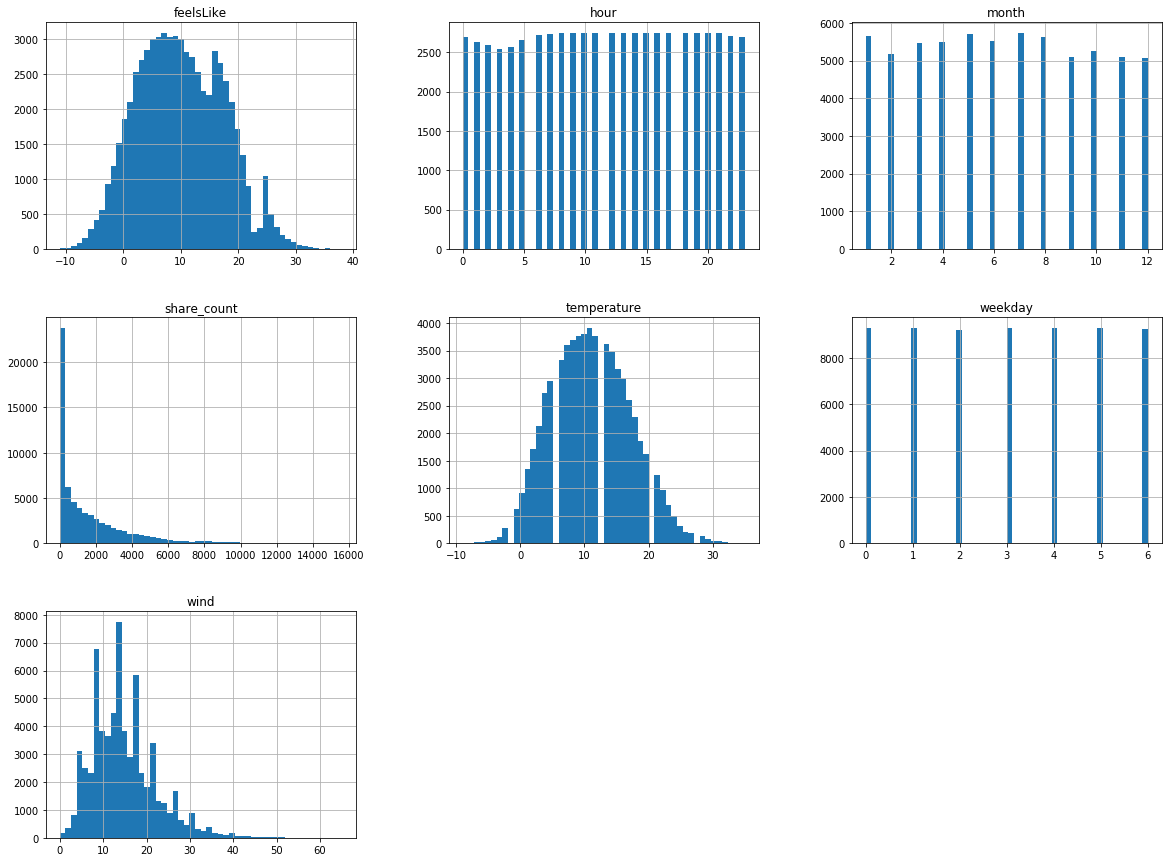

In [11]:
%matplotlib inline
import matplotlib.pyplot as plt
bike_share_df.hist(bins=50, figsize=(20,15))
plt.show()

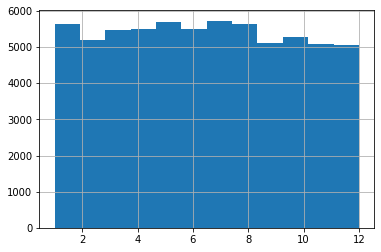

In [12]:
bike_share_df['month'].hist(bins=12)

In [13]:
bike_share_df['weatherCode'].value_counts()

113    16416
116    16233
122    11372
119     8266
143     3276
248     2451
176     1855
353     1364
266     1028
296      871
302      433
200      257
263      190
356      116
338       95
260       75
299       72
389       71
317       69
332       61
293       60
308       52
230       41
371       39
326       38
386       15
329       13
227       12
362       12
368       12
323       12
305        9
335        6
320        6
359        6
Name: weatherCode, dtype: int64

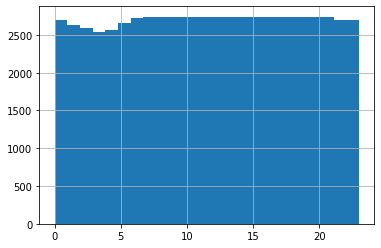

In [14]:
bike_share_df['hour'].hist(bins=24)

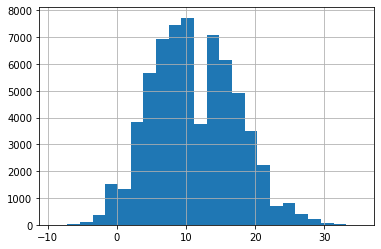

In [15]:
bike_share_df['temperature'].hist(bins=24)

In [16]:
bike_share_df[bike_share_df['share_count'] <= 100].shape

(15482, 11)

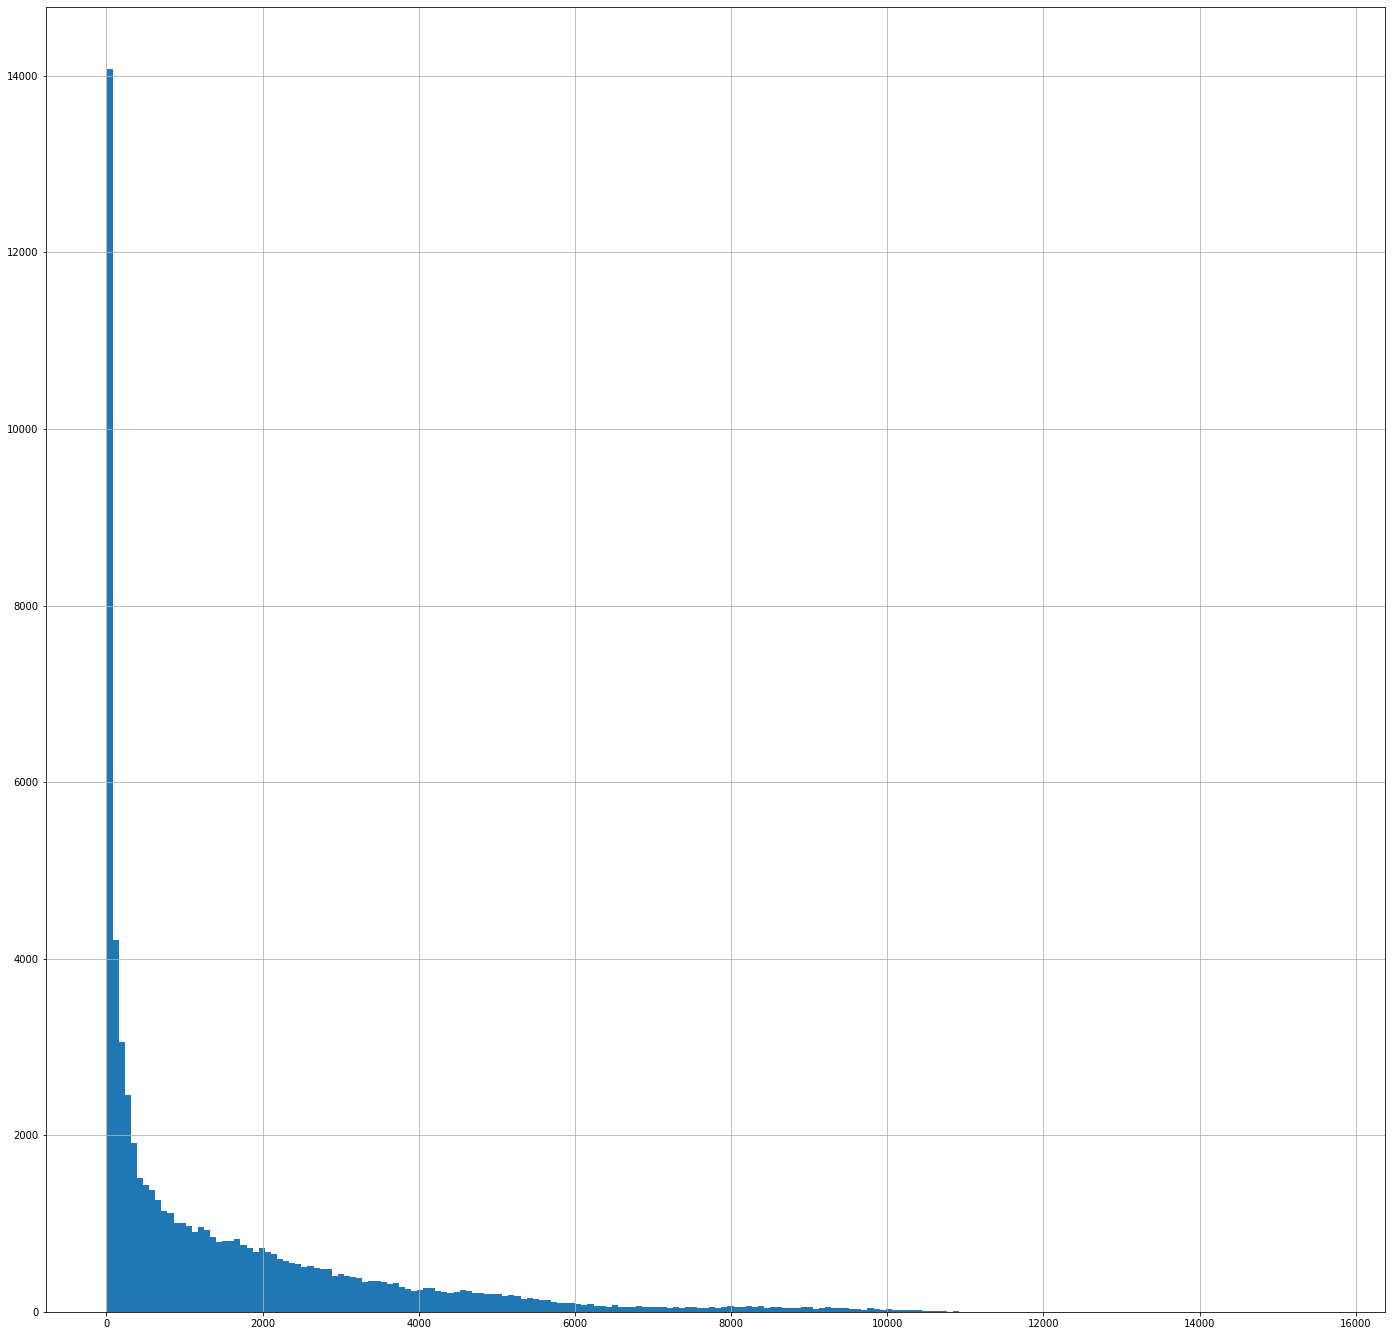

In [17]:
bike_share_df['share_count'].hist(bins=200, figsize=(24,24))

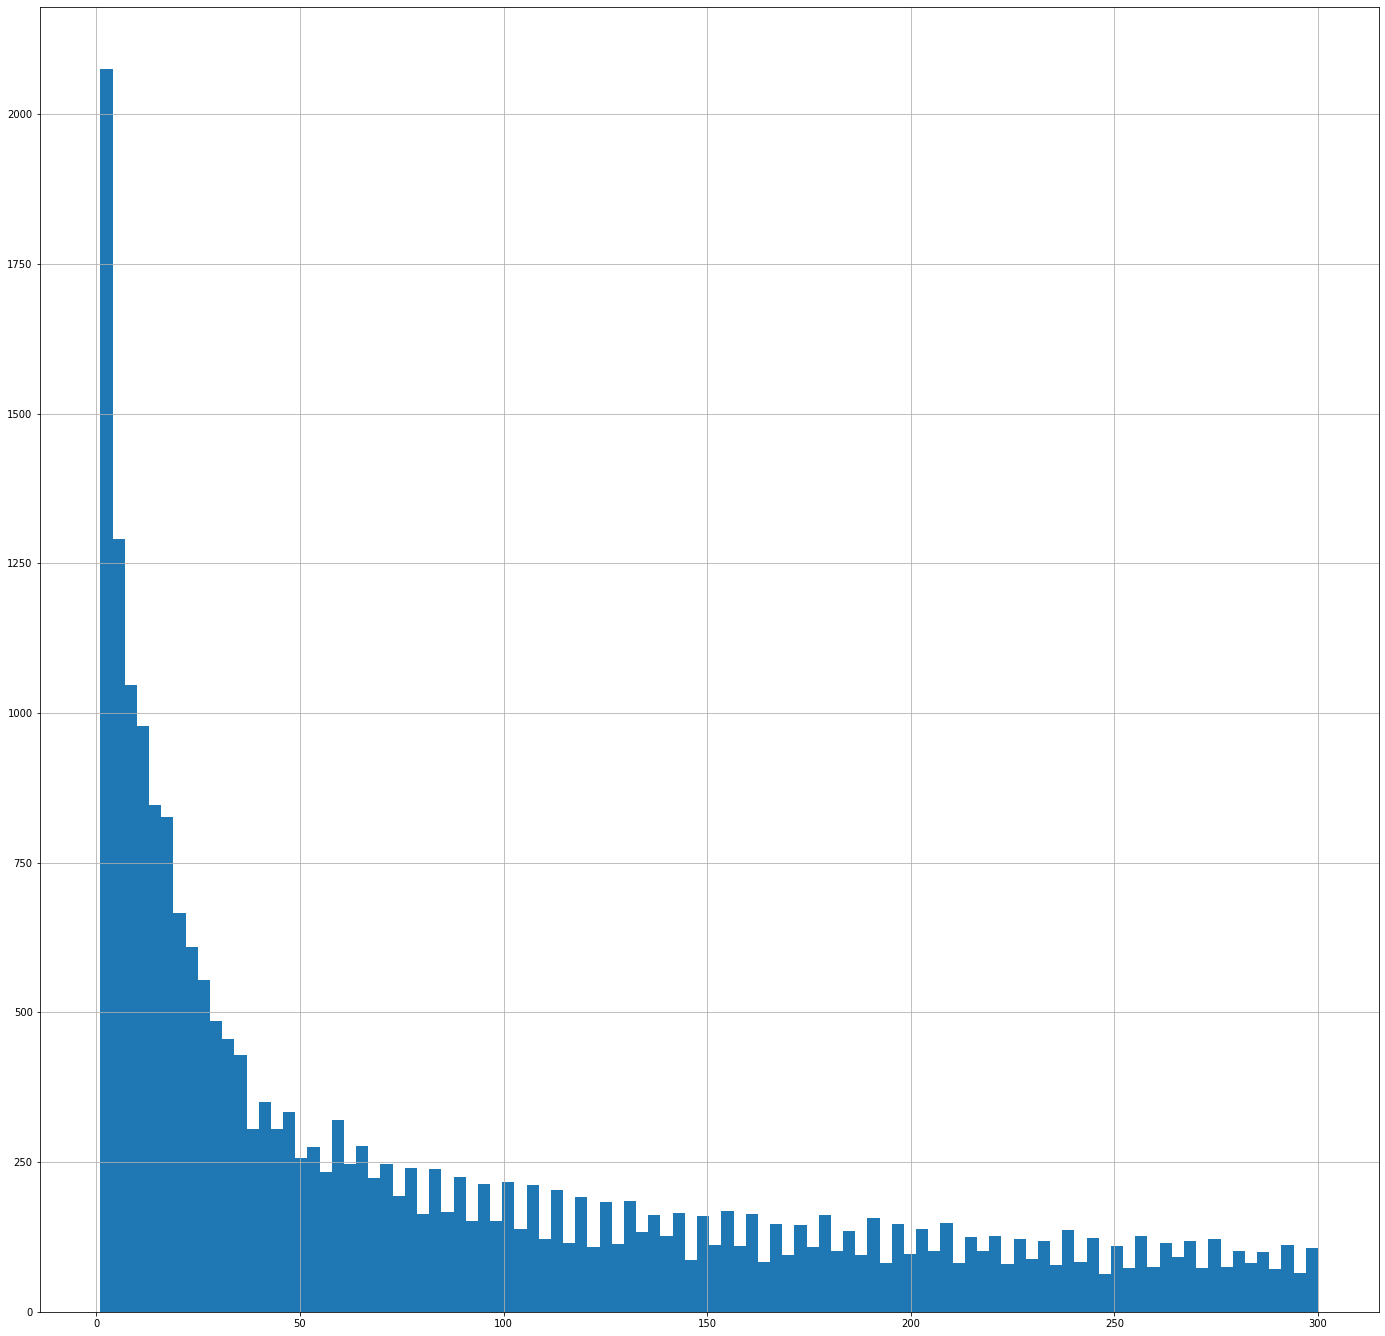

In [18]:
bike_share_df[bike_share_df['share_count'] <= 300]['share_count'].hist(bins=100, figsize=(24,24))

In [19]:
# WEATHER_CODE: [GROUP_NAME]
new_codes = {
    '113': 'Clear', # Clear, Sunny
    '116': 'Cloudy', # Partly cloudy
    '122': 'Cloudy', # Overcast
    '119': 'Cloudy', # Cloudy
    '143': 'Lowered visibility', # Mist
    '176': 'Light rain', # Patchy rain possible
    '296': 'Light rain', # Light rain
    '308': 'Heavy rain', # Heavy rain
    '302': 'Heavy rain', # Moderate rain
    '353': 'Light rain', # Light rain shower
    '266': 'Light rain', # Light drizzle
    '356': 'Heavy rain', # Moderate or heavy rain shower
    '293': 'Light rain', # Patchy light rain
    '248': 'Lowered visibility', # Fog
    '200': 'Thunder', # Thundery outbreaks possible
    '299': 'Heavy rain', # Moderate rain at times
    '263': 'Light rain', # Patchy light drizzle
    '317': 'Light snow', # Light sleet
    '386': 'Thunder', # Patchy light rain with thunder
    '230': 'Blizzard', # Blizzard
    '329': 'Heavy snow', # Patchy moderate snow
    '332': 'Heavy snow', # Moderate snow
    '338': 'Heavy snow', # Heavy snow
    '326': 'Light snow', # Light snow
    '362': 'Light snow', # Light sleet showers
    '389': 'Thunder', # Moderate or heavy rain with thunder
    '311': 'Light snow', # Light freezing rain
    '359': 'Heavy rain', # Torrential rain shower
    '323': 'Light snow', # Patchy light snow
    '260': 'Lowered visibility', # Freezing fog
    '368': 'Light snow', # Light snow showers
    '371': 'Heavy snow', # Moderate or heavy snow showers
    '305': 'Heavy rain', # Heavy rain at times
    '320': 'Heavy snow', # Moderate or heavy sleet
    '335': 'Heavy snow', # Patchy heavy snow
    '227': 'Heavy snow', # Blowing snow
}

bike_share_df['weatherCode'] = bike_share_df['weatherCode'].map(lambda x: new_codes[x])
bike_share_df['weatherCode'].value_counts()

Cloudy                35871
Clear                 16416
Lowered visibility     5802
Light rain             5368
Heavy rain              688
Thunder                 343
Heavy snow              232
Light snow              143
Blizzard                 41
Name: weatherCode, dtype: int64

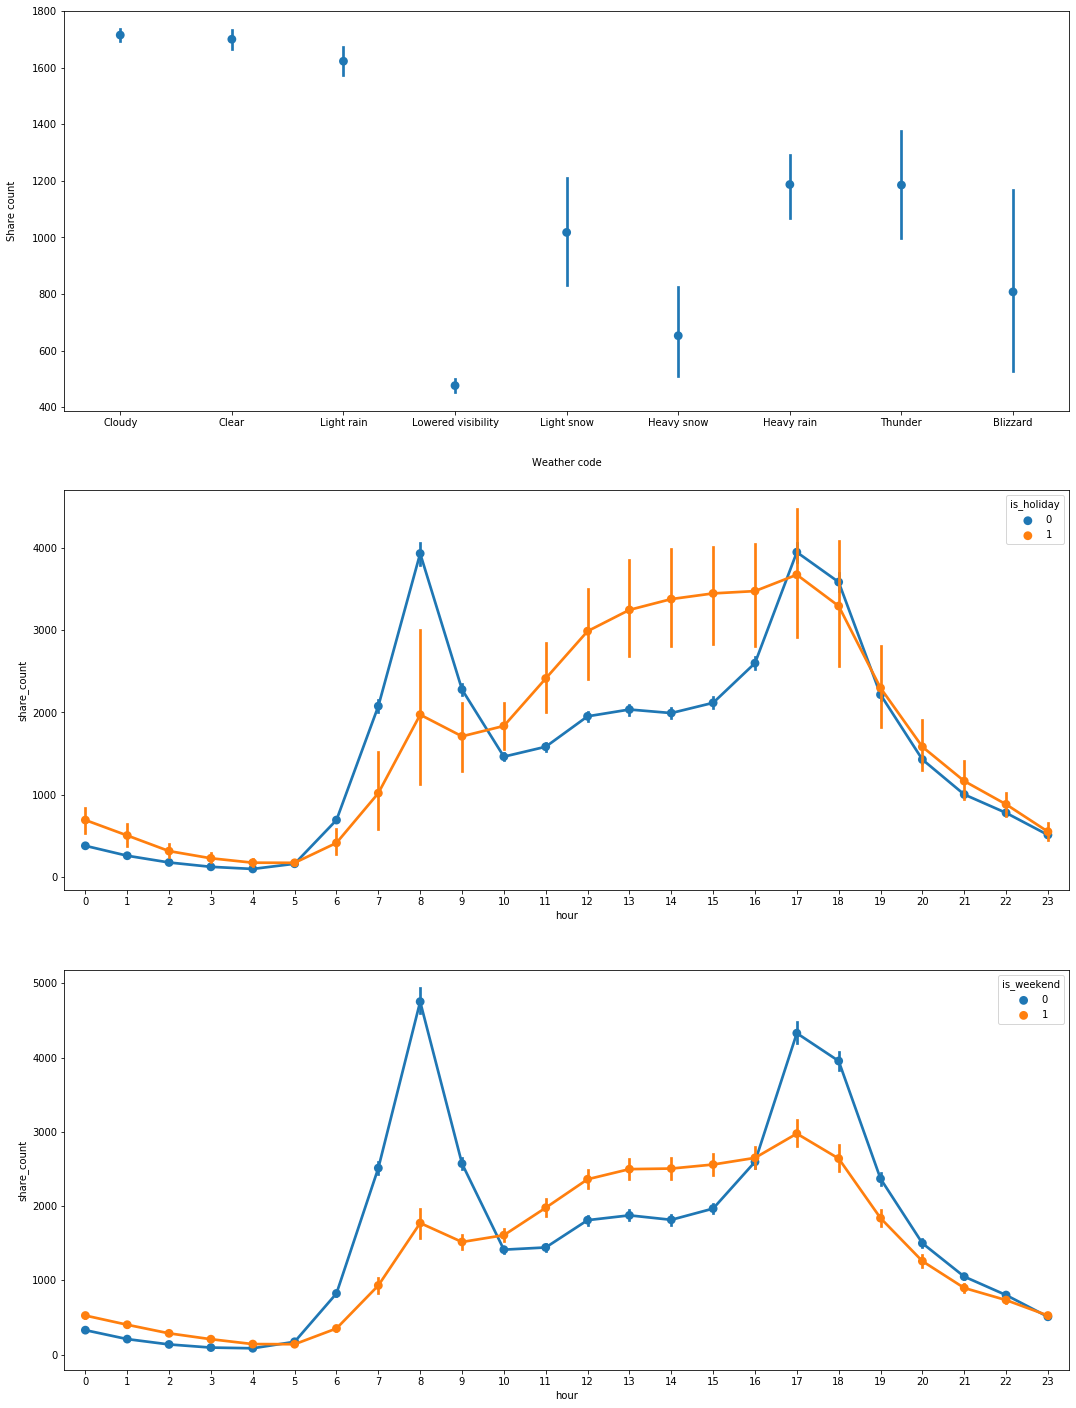

In [20]:
fig,(ax1, ax2, ax3)= plt.subplots(nrows=3)
fig.set_size_inches(fig_size)

sns.pointplot(data=bike_share_df, x='weatherCode', y='share_count', ax=ax1, join=False)
sns.pointplot(data=bike_share_df, x='hour', y='share_count', hue='is_holiday', ax=ax2)
sns.pointplot(data=bike_share_df, x='hour', y='share_count', hue='is_weekend', ax=ax3)
ax1.set_xlabel('Weather code', labelpad=30)
_ = ax1.set_ylabel('Share count', labelpad=15)

### Dealing with cyclical data

In [21]:
import numpy as np

bike_share_df['hr_sin'] = np.sin(bike_share_df.hour*(2.*np.pi/24))
bike_share_df['hr_cos'] = np.cos(bike_share_df.hour*(2.*np.pi/24))
bike_share_df['mnth_sin'] = np.sin((bike_share_df.month-1)*(2.*np.pi/12))
bike_share_df['mnth_cos'] = np.cos((bike_share_df.month-1)*(2.*np.pi/12))
bike_share_df = bike_share_df.drop(['month', 'hour'], axis=1)

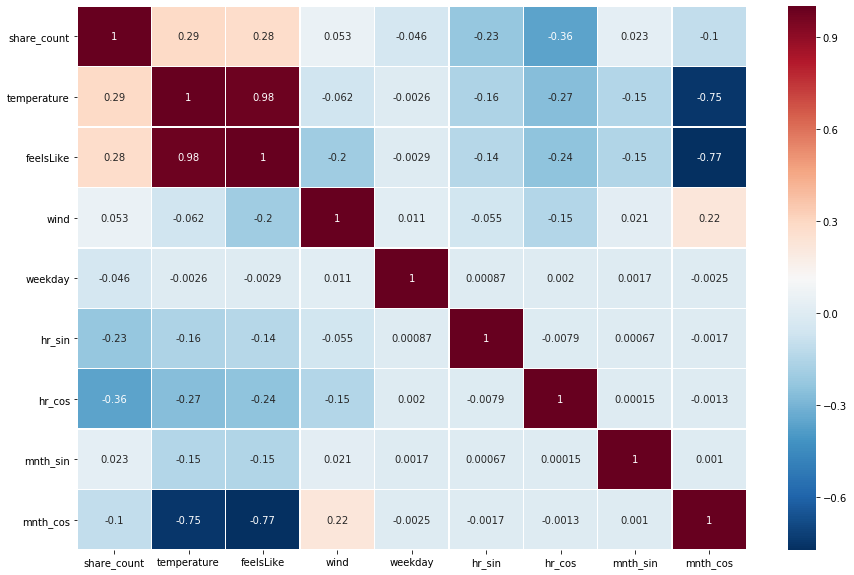

In [22]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(15,10)

pearsoncorr = bike_share_df.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
           ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

In [23]:
bike_share_df_lag = bike_share_df.sort_values('Start Date')

bike_share_df_lag['lag_1'] = bike_share_df_lag['share_count'].shift(1)
bike_share_df_lag['lag_2'] = bike_share_df_lag['share_count'].shift(2)
bike_share_df_lag['lag_3'] = bike_share_df_lag['share_count'].shift(3)

bike_share_df_lag = bike_share_df_lag[3:].reset_index(drop=True)

bike_share_df_lag.head()
bike_share_df = bike_share_df_lag.copy()

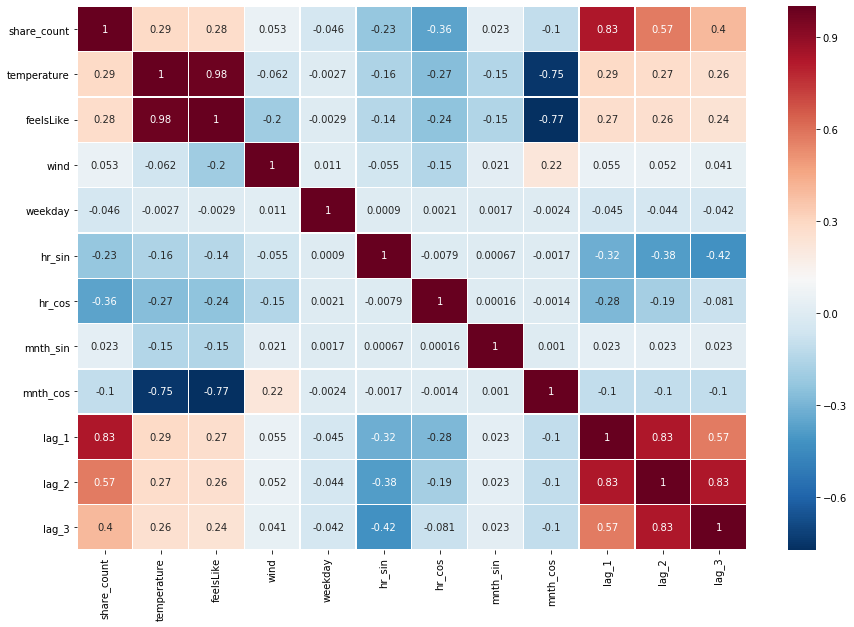

In [24]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(15,10)

pearsoncorr = bike_share_df.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
           ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

### Deal with labeled data

In [25]:
encoded_weather_codes = pd.get_dummies(bike_share_df['weatherCode'], prefix='weather')
bike_share_df_enc = bike_share_df.drop(['weatherCode'], axis=1)
bike_share_df_enc = bike_share_df_enc.join(encoded_weather_codes)

In [26]:
holiday_enc = pd.get_dummies(bike_share_df['is_holiday'], prefix='holiday')
week_enc = pd.get_dummies(bike_share_df['is_weekend'], prefix='weekend')
bike_share_df_enc = bike_share_df_enc.join(holiday_enc).join(week_enc)
bike_share_df_enc = bike_share_df_enc.drop(['is_holiday', 'is_weekend'], axis=1)
# "weekday" could be dropped due to the fact that we have "is_weekend"
bike_share_df_enc = bike_share_df_enc.drop(['weekday'], axis=1)

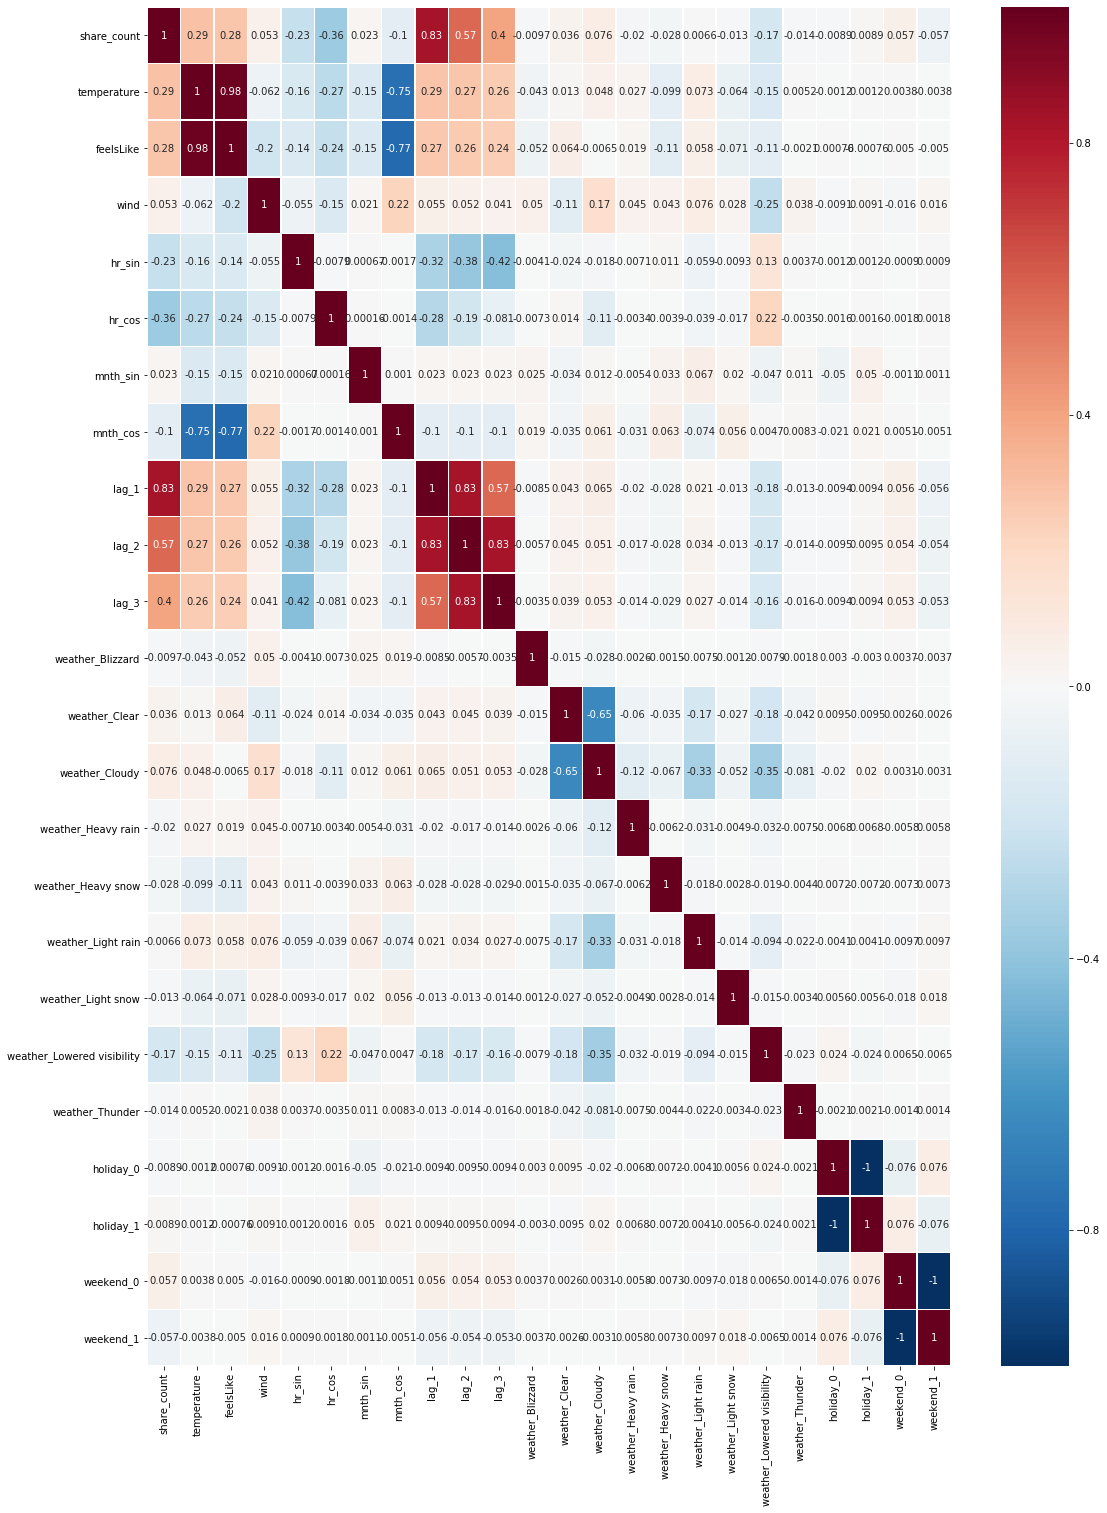

In [27]:
fig, ax= plt.subplots(nrows=1)
fig.set_size_inches(fig_size)

pearsoncorr = bike_share_df_enc.drop('Start Date', axis=1).corr(method='pearson')
heat_map=sns.heatmap(pearsoncorr, 
            xticklabels=pearsoncorr.columns,
            yticklabels=pearsoncorr.columns,
            cmap='RdBu_r',
            annot=True,
            linewidth=0.5,
           ax=ax)
_ = heat_map.set_yticklabels(heat_map.get_yticklabels(), rotation=0)

In [28]:
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC, SVR
from sklearn.gaussian_process import GaussianProcessClassifier
from sklearn.gaussian_process.kernels import RBF
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingRegressor
from sklearn.naive_bayes import GaussianNB
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.linear_model import Lasso, ElasticNet, Ridge, SGDRegressor

In [29]:
train_set, test_set = train_test_split(bike_share_df_enc, test_size=0.3, random_state=random_state)

train_set = train_set.drop('Start Date', axis=1)
test_set = test_set.drop('Start Date', axis=1)

X_train = train_set.drop('share_count', axis=1).to_numpy()
Y_train = train_set['share_count'].to_numpy()

X_test = test_set.drop('share_count', axis=1).to_numpy()
Y_test = test_set['share_count'].to_numpy()

In [30]:
classifiers = [
    ('Decision Tree', DecisionTreeClassifier()),
#     ('Random Forest', RandomForestClassifier(n_estimators=100)),
#     ('NN (50, 50, 16)', MLPClassifier(hidden_layer_sizes=(50, 50, 50), learning_rate='adaptive', activation='tanh', learning_rate_init=0.01)),
    ('Lasso', Lasso(random_state=random_state)),
    ('ElasticNet', ElasticNet(random_state=random_state)),
    ('Ridge', Ridge(random_state=random_state)),
#     ('SVR linear', SVR(kernel='linear', verbose=True)),
#     ('SVR rbf', SVR(kernel='rbf', verbose=True)),
    ('SGDRegressor', SGDRegressor()),
    ('GradientBoostRegressor', GradientBoostingRegressor())
]

In [31]:
import time
def learn(classifiers, X_train, Y_train, X_test, Y_test):
    for name, clf in classifiers:
        print(f'** {name}')
        t0 = time.time()
        clf.fit(X_train, Y_train)
        t1 = time.time()
        score_train = clf.score(X_train[:10000], Y_train[:10000])
        t2 = time.time()
        score_test = clf.score(X_test, Y_test)
        t3 = time.time()
        print(f'\tTraining time {t1 - t0:3.3f}')
        print(f'\tPrediction time (train) {t2 - t1:3.3f}')
        print(f'\tPrediction time (test) {t3 - t2:3.3f}')
        print(f'\tScore train: {score_train:.3f}\tScore Test: {score_test:.3f}')

In [32]:
# learn(classifiers, X_train, Y_train, X_test, Y_test)

In [33]:
# # Search through param_grid parameters, find the best set of parameters for GBR (Gradient Boosting Regressor)
# param_grid = [
#     {'max_features': [21], 'max_depth': [3, 10, 20, 50, 100]}
#   ]

# clf = GradientBoostingRegressor(random_state=random_state)

# grid_search = GridSearchCV(clf, param_grid, cv=5,
#                            scoring='neg_mean_squared_error', return_train_score=True)
# grid_search.fit(X_train, Y_train)

# # Run GBR with best set of parameters
# clf = GradientBoostingRegressor(random_state=random_state,
#                                 **grid_search.best_params_,
#                                 n_estimators=2000)

# clf.fit(X_train, Y_train)
# results = clf.predict(X_test)
# score = clf.score(X_test, Y_test)
# print("TEST SCORE: " + str(score))

In [34]:
X_test.shape

(19471, 23)

In [35]:
optimized_clf = GradientBoostingRegressor(loss='huber', max_features=X_test.shape[1], n_estimators=160, random_state=random_state, max_depth=8)
optimized_clf.fit(X_train, Y_train)
results = optimized_clf.predict(X_test)

test_score = optimized_clf.score(X_test, Y_test)
train_score = optimized_clf.score(X_train, Y_train)
print("Test score: " + str(test_score))
print("Train score: " + str(train_score))

Test score: 0.9806035752208188
Train score: 0.9892487275130167


In [36]:
from sklearn.metrics import mean_squared_error

lin_mse = mean_squared_error(Y_test, results)
lin_rmse = np.sqrt(lin_mse)

In [37]:
from sklearn.metrics import mean_absolute_error

lin_mae = mean_absolute_error(Y_test, results)

In [38]:
# count negative
results[results < 0].shape

(86,)

In [39]:
from sklearn.metrics import explained_variance_score, max_error, confusion_matrix
y_true = Y_test
y_pred = results
var_score = explained_variance_score(y_true, y_pred)  

In [40]:
print("Mean squared error: " + str(lin_rmse))
print("Mean absolute error: " + str(lin_mae))
print("Max error: " + str(max_error(y_true, y_pred)))
print("Variance score: " + str(var_score))

Mean squared error: 277.6673569154791
Mean absolute error: 142.97563385686774
Max error: 5029.697259033511
Variance score: 0.9806044030415209


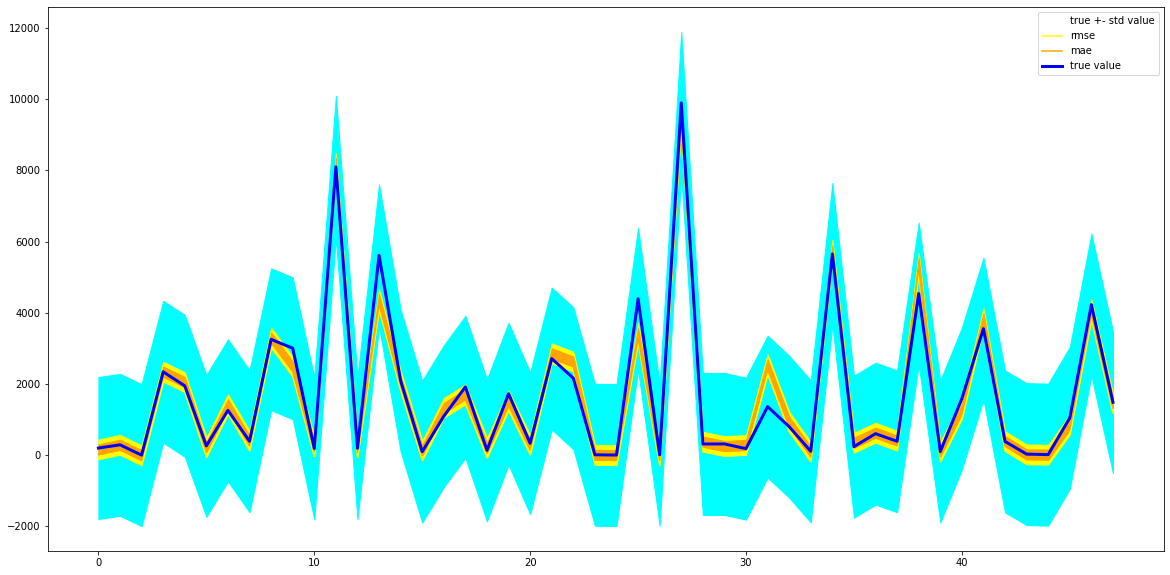

In [41]:
range_limit = [12040, 12088]

plt.rcParams["figure.figsize"] = (20,10)

lower_std_line = plt.plot(y_true[range_limit[0]:range_limit[1]] - 1000, color="cyan", visible=False, linewidth=3, label="true +- std value")

lower_line_rmse = plt.plot(y_pred[range_limit[0]:range_limit[1]] - lin_rmse, color="yellow", label="rmse")
lower_line_mae = plt.plot(y_pred[range_limit[0]:range_limit[1]] - lin_mae, color="orange", label="mae")

true_line = plt.plot(y_true[range_limit[0]:range_limit[1]], color="blue", linewidth=3, label="true value")


indexes = []
index = 0
for i in range (range_limit[0], range_limit[1]):
    indexes.append(index)
    index += 1

std = np.std(y_true)
    
plt.fill_between(indexes, y_true[range_limit[0]:range_limit[1]] - std, y_true[range_limit[0]:range_limit[1]] + std, color="cyan")
plt.fill_between(indexes, y_pred[range_limit[0]:range_limit[1]] - lin_rmse, y_pred[range_limit[0]:range_limit[1]] + lin_rmse, color="yellow")
plt.fill_between(indexes, y_pred[range_limit[0]:range_limit[1]] - lin_mae, y_pred[range_limit[0]:range_limit[1]] + lin_mae, color="orange")

plt.legend()
plt.show()